# Sleep Stage Scoring (on raw EEG signal)

What is different from [this version](https://github.com/baroquerock/sleep-stages-scoring):
1. Pytorch framework
2. Multichannel input
3. Different architecture

New architecture accomodates two channels:

<img src="img/arch2.png" width="800" height="1000">

In [1]:
import random
import numpy as np
import pandas as pd
import os
import re
import copy
import time

import matplotlib.pyplot as plt
import torch
from torch import optim, nn
from torchvision import transforms, datasets, models

from collections import OrderedDict

from npzloader import DataLoader as DataLoader_x
import torch.utils.data as utils

from sklearn.preprocessing import LabelBinarizer

import warnings
warnings.filterwarnings("ignore")

In [2]:
# loading fpz_cz and pz_oz channels
loader = DataLoader_x("data/fpz_cz")
data_fp, labels = loader.load_data(verbose=0)
data_fp = {''.join(k.partition('fpz_cz')[1:]) : v for k, v in data_fp.items()} 

loader = DataLoader_x("data/pz_oz")
data_pz, _ = loader.load_data(verbose=0)
data_pz = {''.join(k.partition('pz_oz')[1:]) : v for k, v in data_pz.items()} 

all_labels = np.hstack(labels.values())

In [3]:
# int-to-label map
class_dict = {0: "W", 
              1: "N1",
              2: "N2",
              3: "N3",
              4: "REM"}

### TRAINING

In [4]:
"""
Function to randomly select subjects for partial cross-validation and prepare the data for training.
Train and test sets should be independent.
A patient with is SC413 is excluded from any test set because this patient has only one recording.
"""
def get_cv_data(data, labels, n_folds=5, ch='fpz_cz'):
    
    random.seed(29)
    test_key = []
    keys = list(labels.keys())
    keys = list(set([x[:5] for x in keys if '413' not in x]))
    for i in range(len(keys)):
        if "419" in keys[i]:
            test_key = [keys[i]]
    random.shuffle(keys)
    print(test_key)
    val_keys = keys[:n_folds]
 
    cv_data = []
    test_key = [test_key[0] + '1E0',test_key[0] + '2E0']
    
    for fold in val_keys:
        fold_keys = [fold+'1E0', fold+'2E0']
        
        val_labels = [labels[key] for key in fold_keys]
        val_labels = np.hstack(val_labels)
        
        keys_not_training = fold_keys + test_key
        
        train_labels = [labels[key] for key in labels.keys() if key not in keys_not_training]
        train_labels = np.hstack(train_labels)
       
        test_labels=[labels[key] for key in test_key]
        test_labels= np.hstack(test_labels)
        
        if ch:
            val_data = [data['{}/{}'.format(ch,key)] for key in fold_keys]
            train_data = [data['{}/{}'.format(ch,key)] for key in labels.keys() if key not in keys_not_training]   
            test_data = [data['{}/{}'.format(ch,key)] for key in test_key]
        else:
            val_data = [data[key] for key in fold_keys]
            train_data = [data[key] for key in labels.keys() if key not in keys_not_training]
            test_data = [data[key] for key in labels.keys() if key in test_key]
           
        train_data = np.vstack(train_data)
        val_data = np.vstack(val_data)
        test_data = np.vstack(test_data)
    
        cv_data.append((train_data, train_labels, val_data, val_labels, test_data, test_labels))
    
    return cv_data 

"""
Function to slide on array with a moving window of size n
"""

def _slide(data, labels, n=3):
    
    #zero-indexing
    data = [data[i:i+n] for i, _ in enumerate(data[n:])]
    data = [np.vstack(x) for x in data]
    data = np.array(data)
    
    labels = labels[n:]
    
    assert data.shape[0] == labels.shape[0]
    
    return data, labels

"""
Function to do batch processing with _slide()
"""

def batch_slide(data_dict, labels_dict, n=3):
    
    keys = [(x,y) for x,y in zip(data_dict, labels_dict)]
    data = [_slide(data_dict[x], labels_dict[y], n=n) for x,y in keys]
    
    data_keys, label_keys = zip(*keys)
    data, labels = zip(*data)
    
    data_dict = {k:v for k,v in zip(data_keys, data)}
    data_dict = OrderedDict(sorted(data_dict.items()))
    
    labels_dict = {k:v for k,v in zip(label_keys, labels)}
    labels_dict = OrderedDict(sorted(labels_dict.items()))
        
    return data_dict, labels_dict 
  
  
"""
Function to merge channels into single recording.
axis = 0: merge channels along the first dimension - (3000,1) and (3000,1) --> (6000,1)
axis = 0: merge channels along the second dimension - (3000,1) and (3000,1) --> (3000,2)
"""  
    
def merge_channels(channels, axis=0):
    
    # number of records should be the same in all channels
    assert len(set([len(r) for r in channels])) == 1
    
    keys = [ch.keys() for ch in channels]
    
    merged = {}
    
    for records in zip(*keys):
        
        # assert that all recordings are for the same patient
        assert len(set([r.split('/')[1] for r in records])) == 1
        vals = [ch[r] for r, ch in zip(records, channels)]
        if axis:
            stacked = np.dstack(vals)
        else:
            stacked = np.hstack(vals)
        patient = records[0].split('/')[1]
        merged[patient] = stacked
        
    merged = OrderedDict(sorted(merged.items()))
    return merged


In [5]:
data_all = merge_channels([data_fp, data_pz], axis=1)

In [6]:
# getting cross-valivation data
# note: n_folds is not a number of folds in traditional sense
# the model is trained on 19 patients and validated on 1,
# so n_folds is a number of patients for validation
# to perform full cross-validation n_folds should be equal to 19 
# (not 20, because for SC413 patient there is only one record)
cv_data = get_cv_data(data_all, labels, ch=None, n_folds=5)

['SC419']


In [7]:
def small_conv(fs): 
    return nn.Sequential(
            nn.Conv1d(1, 64, kernel_size=fs//2, stride=fs//16, padding=2),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.MaxPool1d(kernel_size=8, stride=8),
            
            nn.Conv1d(64, 64, kernel_size=8, padding=2),
            nn.ReLU(),
            nn.Conv1d(64, 64, kernel_size=8, padding=2),
            nn.ReLU(), 
            nn.Conv1d(64, 64, kernel_size=8, padding=2),
            nn.ReLU())

def big_conv(fs): 
    return nn.Sequential(
            nn.Conv1d(1, 64, kernel_size=fs*4, stride=fs//2, padding=2),
            nn.ReLU(), 
            nn.Dropout(0.3),
            nn.MaxPool1d(kernel_size=4, stride=4),
            
            nn.Conv1d(64, 64, kernel_size=6, padding=2),
            nn.ReLU(),
            nn.Conv1d(64, 64, kernel_size=6, padding=2),
            nn.ReLU(), 
            nn.Conv1d(64, 64, kernel_size=6, padding=2),
            nn.ReLU())


class ConvNet(nn.Module):
  
    def __init__(self, n_cnn_dense=256, fs=100, num_classes=5):
      
        super(ConvNet, self).__init__()
        
        self.layer1_fz = small_conv(fs)        
        self.layer2_fz = big_conv(fs)

        self.layer1_pz = small_conv(fs)        
        self.layer2_pz = big_conv(fs)
        
        
        self.fc1 = nn.Sequential(
            nn.Linear(124, n_cnn_dense),
            nn.ReLU(),            
            nn.MaxPool1d(kernel_size=4, stride=4))
        
        self.fc2 = nn.Sequential(
            nn.Linear(4096, num_classes),
            nn.LogSoftmax(dim=1))
        
                
        
    def forward(self, channels):
      
        ch1 = channels[:, 0, :].unsqueeze(1)
        ch2 = channels[:, 1, :].unsqueeze(1)
        
        out1_1 = self.layer1_fz(ch1)
        out2_1 = self.layer2_fz(ch1)
        
        out1_2 = self.layer1_pz(ch2)
        out2_2 = self.layer2_pz(ch2)        
        
        out = torch.cat((out1_1, out2_1, out1_2, out2_2), dim=2)
        out = self.fc1(out)
        s = out.size()[0]
        out = out.view(s, -1)
        out = self.fc2(out)
       
        return out

In [8]:
model = ConvNet()
train_data, train_labels, val_data, val_labels, test_data, test_labels = cv_data[1]

train = utils.TensorDataset(torch.from_numpy(np.swapaxes(train_data,1,2)), torch.from_numpy(train_labels).long())
train_loader = utils.DataLoader(train, batch_size=64, shuffle=True)

valid = utils.TensorDataset(torch.from_numpy(np.swapaxes(val_data,1,2)), torch.from_numpy(val_labels).long())
valid_loader = utils.DataLoader(valid, batch_size=64, shuffle=True)

test = utils.TensorDataset(torch.from_numpy(np.swapaxes(test_data,1,2)), torch.from_numpy(test_labels).long())
test_loader = utils.DataLoader(test, batch_size=64, shuffle=True)
                           
dataloaders = {'train': train_loader, 'valid': valid_loader, "test":test_loader}
dataset_sizes = {'train': len(train), 'valid': len(valid), "test": len(test)}

In [9]:
def train_model(model, criteria, optimizer, scheduler, num_epochs=25, device='cuda'):
    model.to(device)
    since = time.time()
    epoch_loss_array=[] 
    accuracy_array=[]
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        print('-' * 10)

        for phase in ['train', 'valid',"test"]:
            if phase == 'train':
                scheduler.step()
                model.train()  
            else:
                model.eval()   
                
            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

   
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criteria(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_loss_array.append(epoch_loss)
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            accuracy_array.append(epoch_acc)
            

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, epoch_loss_array, accuracy_array

In [10]:
criteria = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.005)
sched = optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.1)
eps=15

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using {}!".format(device))
epoch_loss_array=[] 
accuracy_array=[]
model_ft,epoch_loss_array,accuracy_array= train_model(model, criteria, optimizer, sched, eps, device)


Using cpu!
Epoch 1/15
----------
train Loss: 1.1152 Acc: 0.6199
valid Loss: 0.5742 Acc: 0.7874
test Loss: 0.8625 Acc: 0.6846

Epoch 2/15
----------
train Loss: 0.7834 Acc: 0.7008
valid Loss: 0.5958 Acc: 0.7649
test Loss: 0.9211 Acc: 0.6294

Epoch 3/15
----------
train Loss: 0.7507 Acc: 0.7086
valid Loss: 0.5004 Acc: 0.8150
test Loss: 0.7745 Acc: 0.7095

Epoch 4/15
----------
train Loss: 0.6654 Acc: 0.7441
valid Loss: 0.4966 Acc: 0.8125
test Loss: 0.7339 Acc: 0.7067

Epoch 5/15
----------
train Loss: 0.6526 Acc: 0.7519
valid Loss: 0.4732 Acc: 0.8250
test Loss: 0.7641 Acc: 0.7113

Epoch 6/15
----------
train Loss: 0.6453 Acc: 0.7533
valid Loss: 0.5085 Acc: 0.8021
test Loss: 0.7075 Acc: 0.7312

Epoch 7/15
----------
train Loss: 0.6396 Acc: 0.7560
valid Loss: 0.5022 Acc: 0.8032
test Loss: 0.7628 Acc: 0.7198

Epoch 8/15
----------
train Loss: 0.6245 Acc: 0.7633
valid Loss: 0.4982 Acc: 0.8047
test Loss: 0.7367 Acc: 0.7252

Epoch 9/15
----------
train Loss: 0.6209 Acc: 0.7659
valid Loss: 0.49

Text(0.5, 1.0, "Graphique du résultat de la fonction de perte en fonction de l'époque pour l'ensemble d'entrainement")

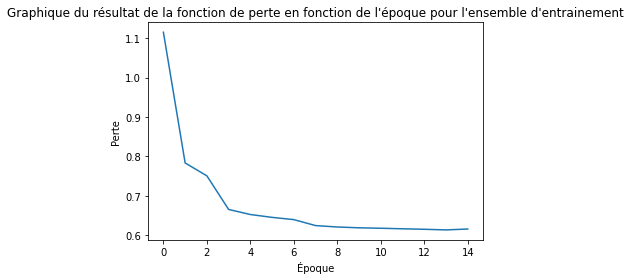

In [26]:
loss_array_train=[]
loss_array_valid=[]
loss_array_test=[]



for i in range(0, len(epoch_loss_array), 3):
    loss_array_train.append(epoch_loss_array[i])
    
for i in range(1, len(epoch_loss_array), 3):
    loss_array_valid.append(epoch_loss_array[i])

for i in range(2, len(epoch_loss_array), 3):
    loss_array_test.append(epoch_loss_array[i])
plt.plot(loss_array_train)
plt.xlabel("Époque")
plt.ylabel("Perte")
plt.title("Graphique du résultat de la fonction de perte en fonction de l'époque pour l'ensemble d'entrainement")


Text(0.5, 1.0, "Graphique du résultat de la fonction de perte en fonction de l'époque pour l'ensemble de validation")

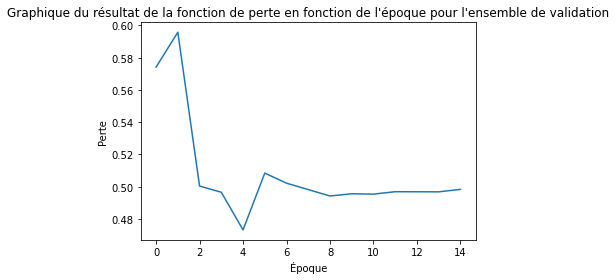

In [27]:
plt.plot(loss_array_valid)
plt.xlabel("Époque")
plt.ylabel("Perte")
plt.title("Graphique du résultat de la fonction de perte en fonction de l'époque pour l'ensemble de validation")

Text(0.5, 1.0, "Graphique du résultat de la fonction de perte en fonction de l'époque pour l'ensemble de test")

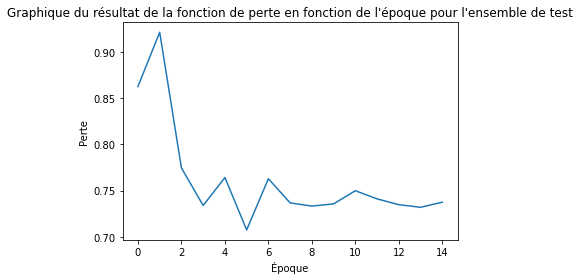

In [28]:
plt.plot(loss_array_test)
plt.xlabel("Époque")
plt.ylabel("Perte")
plt.title("Graphique du résultat de la fonction de perte en fonction de l'époque pour l'ensemble de test")

Text(0.5, 1.0, "Graphique du résultat de la précision du modèle en fonction de l'époque pour l'ensemble d'entrainement")

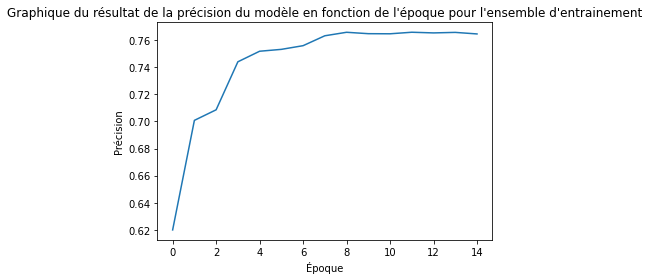

In [29]:
accuracy_array_train=[]
accuracy_array_valid=[]
accuracy_array_test=[]

for i in range(0, len(accuracy_array), 3):
    accuracy_array_train.append(accuracy_array[i])
    
for i in range(1,len(accuracy_array), 3):
    accuracy_array_valid.append(accuracy_array[i])

for i in range(2, len(accuracy_array), 3):
    accuracy_array_test.append(accuracy_array[i])
plt.plot(accuracy_array_train)
plt.xlabel("Époque")
plt.ylabel("Précision")
plt.title("Graphique du résultat de la précision du modèle en fonction de l'époque pour l'ensemble d'entrainement")



Text(0.5, 1.0, "Graphique du résultat de la précision du modèle en fonction de l'époque pour l'ensemble de validation")

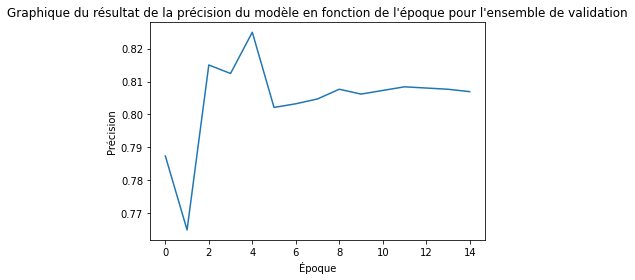

In [30]:
plt.plot(accuracy_array_valid)
plt.xlabel("Époque")
plt.ylabel("Précision")
plt.title("Graphique du résultat de la précision du modèle en fonction de l'époque pour l'ensemble de validation")

Text(0.5, 1.0, "Graphique du résultat de la précision du modèle en fonction de l'époque pour l'ensemble de test")

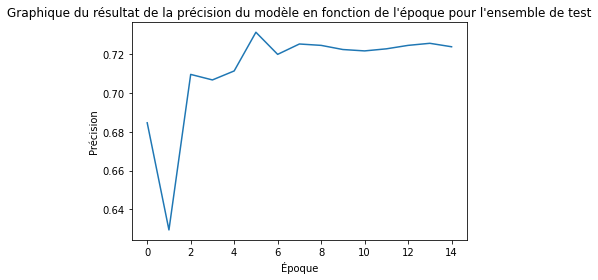

In [31]:
plt.plot(accuracy_array_test)
plt.xlabel("Époque")
plt.ylabel("Précision")
plt.title("Graphique du résultat de la précision du modèle en fonction de l'époque pour l'ensemble de test")